# Визуализация работы RPN

## Зависимости

In [ ]:
!pip install tensorflow
!pip install keras
!pip install pillow
!pip install numpy
!pip install pandas

## Модули и глобальные переменные

In [43]:
from keras.preprocessing.image import load_img, img_to_array
from sources.feature_extractor.processing import prepare_feature_extractor
from sources.feature_extractor.feature_extractor import clean_feature_extractor
from sources.rpn.generation import RPNconfig
from keras.models import Model, load_model
from sources.rpn.rpn import clean_rpn_model, ThresholdedRegularizer, make_cls_wrapper, make_reg_wrapper, expanded_sigmoid
from PIL import Image, ImageDraw, ImageFont
from sources.layers import ApplyDeltas, IndNonMaximumSuppression
import tensorflow as tf
import pandas as pd
import random as rd
import numpy as np

rpn_config = RPNconfig.load_json('rpn/versions/RPN_v7/rpn_config.json')
valid_ab = rpn_config.anchor_boxes[rpn_config.valid_indices]
font = ImageFont.truetype('misc/arial.ttf', size=8)

## Модель

In [44]:
cls_wrapper = make_cls_wrapper(tf.keras.losses.BinaryCrossentropy())
reg_wrapper = make_reg_wrapper(tf.keras.losses.Huber())
rpn = load_model('rpn/versions/RPN_v7/configs/best.h5',
                 custom_objects={'ThresholdedRegularizer': ThresholdedRegularizer,
                                 'cls_wrapper': cls_wrapper,
                                 'reg_wrapper': reg_wrapper,
                                 'expanded_sigmoid': expanded_sigmoid})
layer = ApplyDeltas(rpn_config.anchor_boxes,
                    rpn_config.valid_indices)([rpn.output[0],
                                               rpn.output[1]])
nms = IndNonMaximumSuppression(iou_threshold=0.5,
                               rois_number=256)(layer)
model = Model(inputs=rpn.input, outputs=[layer, nms, rpn.output[0]])

/home/mocurin/snap/jupyter/common/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output FeatureMap missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to FeatureMap.
  'be expecting any data to be passed to {0}.'.format(name))


## Загрузка данных

In [11]:
df = pd.read_json('samples.json')

## Обработка изображений и наглядное представление результатов

In [29]:
def draw_rect(draw, region, color):
    x0, y0, x1, y1 = region
    draw.rectangle([(x0, y0), (x1, y1)], outline=color)
    
def draw_line(draw, line, color):
    x0, y0, x1, y1 = line
    draw.line([(x0, y0), (x1, y1)], fill=color)

def draw_text(draw, point, text, color):
    draw.text(point, text=text, font=font, fill=color)
    
def center_to_corners(regions):
    x, y, w, h = np.transpose(regions)
    x0 = x - w // 2
    y0 = y - h // 2
    x1 = x + w // 2
    y1 = y + h // 2
    return np.transpose([x0, y0, x1, y1]).astype(int)


def prep_img(path, image_size):
    image = load_img(path, target_size=(image_size[1], image_size[0]), interpolation='lanczos')
    image.show()
    image = img_to_array(image)
    image = np.transpose(image, axes=[1, 0, 2])
    image = np.expand_dims(image, axis=0)
    return np.divide(image, 255.)
    
def process_sample(index):
    filename = df.loc[index]['filename']
    gt_boxes = df.loc[index]['gt_boxes']
    image = prep_img('samples/' + filename,  (1280, 720))

    regions, indices, cls = model.predict(image)
    indices = np.squeeze(indices)
    cls = np.squeeze(cls)[indices]

    center_ab = valid_ab[indices]
    corners_ab = center_to_corners(center_ab)

    center_reg = np.squeeze(regions)[indices, 1:].astype(int)
    corners_reg = center_to_corners(center_reg)

    image = Image.open('samples/' + filename)
    draw = ImageDraw.Draw(image)
    for region in corners_ab:
        draw_rect(draw, region, 'orange')
    for line in np.hstack([center_ab[:, :2],
                           center_reg[:, :2]]):
        draw_line(draw, line, 'yellow')
    for i, region in enumerate(corners_reg):
        draw_rect(draw, region, 'red')
        draw_text(draw, (region[0], region[1]), str(round(cls[i], 2)), 'red')
    for region in gt_boxes:
        draw_rect(draw, region, 'green')
    display(image)

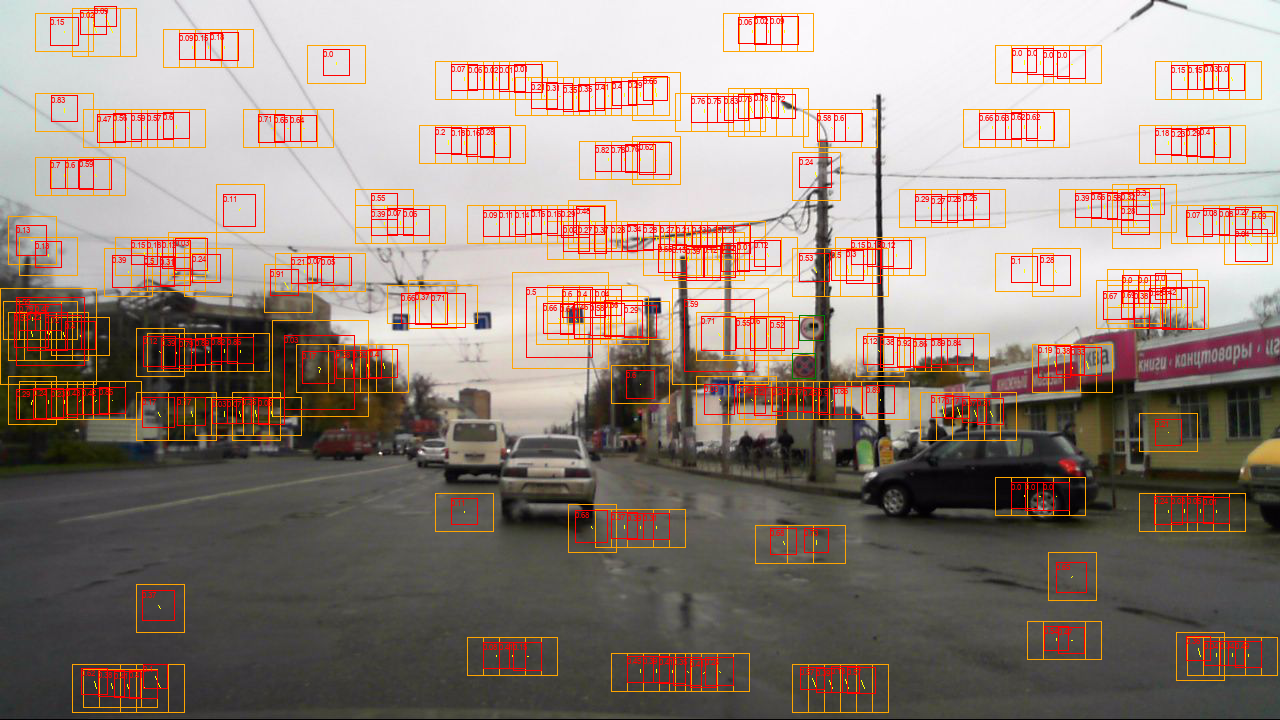

In [49]:
process_sample(91)